In [1]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, GlobalAveragePooling2D, Dense
from tensorflow.keras.layers import BatchNormalization
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
dataset_dir = "../Dataset - Prepo, Cleaning, Visualization/Skin Type"

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Validation and test data (no augmentation, only rescale)
test_val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Test generator
test_generator = test_val_datagen.flow_from_directory(
    directory=dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    directory=dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

# Validation generator
val_generator = test_val_datagen.flow_from_directory(
    directory=dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)

Found 1564 images belonging to 4 classes.
Found 1253 images belonging to 4 classes.
Found 311 images belonging to 4 classes.


In [3]:
# Get class labels from training generator
labels = train_generator.classes  # Ground-truth labels from the training set

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

# Convert to dictionary format
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: 0.8032051282051282, 1: 1.3922222222222222, 2: 1.061864406779661, 3: 0.9132653061224489}


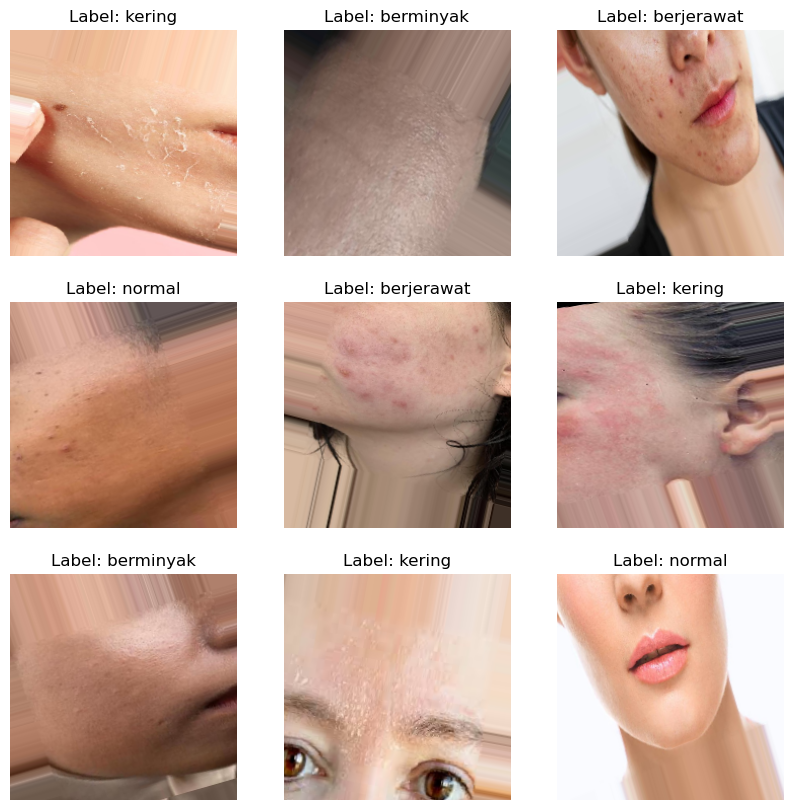

In [4]:
# Function to plot images
def plot_images(images, labels, class_indices, num_images=9):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        ax = plt.subplot(3, 3, i + 1)
        ax.imshow(images[i])  # Display the image
        ax.axis('off')  # Hide axes
        class_label = labels[i]
        class_name = list(class_indices.keys())[list(class_indices.values()).index(class_label)]
        plt.title(f"Label: {class_name}")  # Show the class label
    plt.show()

# Get a batch of images and labels
images, labels = next(train_generator)

# Plot a few images
plot_images(images, labels, train_generator.class_indices)

In [5]:
# Load pre-trained MobileNetV2
conv_base = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze all layers initially
conv_base.trainable = False


In [6]:
model = Sequential([
    conv_base,  # Pre-trained base
    Conv2D(64, (3, 3), activation='relu'), 
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(4, activation='softmax')  # 4 classes for output
])

In [7]:
# Compile the model
model.compile(optimizer='nadam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 64)          737344    
                                                                 
 batch_normalization (BatchN  (None, 5, 5, 64)         256       
 ormalization)                                                   
                                                                 
 global_average_pooling2d (G  (None, 64)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                        

In [8]:
# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-4
)

# Fit the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/100
40/40 [==============================] - 32s 523ms/step - loss: 0.8318 - accuracy: 0.6872 - val_loss: 1.1656 - val_accuracy: 0.7138 - lr: 0.0010
Epoch 2/100
40/40 [==============================] - 13s 312ms/step - loss: 0.5717 - accuracy: 0.8021 - val_loss: 1.2977 - val_accuracy: 0.6431 - lr: 0.0010
Epoch 3/100
40/40 [==============================] - 13s 328ms/step - loss: 0.5159 - accuracy: 0.8180 - val_loss: 0.5072 - val_accuracy: 0.8232 - lr: 0.0010
Epoch 4/100
40/40 [==============================] - 15s 368ms/step - loss: 0.4679 - accuracy: 0.8276 - val_loss: 0.5338 - val_accuracy: 0.8167 - lr: 0.0010
Epoch 5/100
40/40 [==============================] - 12s 307ms/step - loss: 0.4243 - accuracy: 0.8579 - val_loss: 0.5102 - val_accuracy: 0.8135 - lr: 0.0010
Epoch 6/100
40/40 [==============================] - 12s 311ms/step - loss: 0.4220 - accuracy: 0.8540 - val_loss: 0.5166 - val_accuracy: 0.8296 - lr: 0.0010
Epoch 7/100
40/40 [==============================] - 14s 3

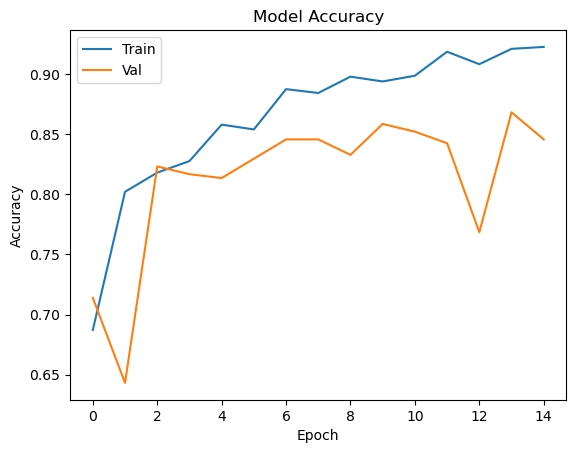

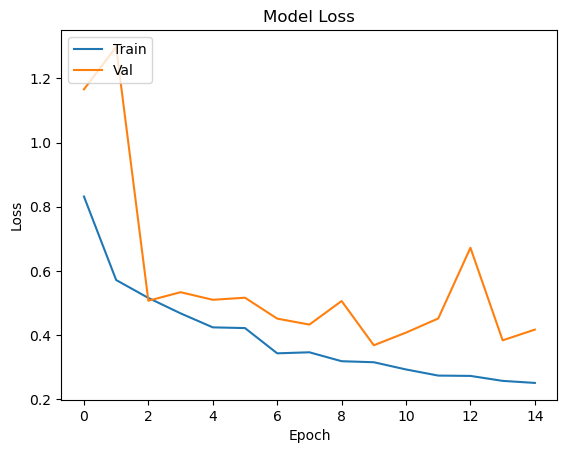

In [9]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


In [10]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

48/48 [==============================] - 4s 90ms/step - loss: 0.2073 - accuracy: 0.9303
Test Accuracy: 93.03%
Test Loss: 0.2073


1/1 [==============================] - 1s 522ms/step


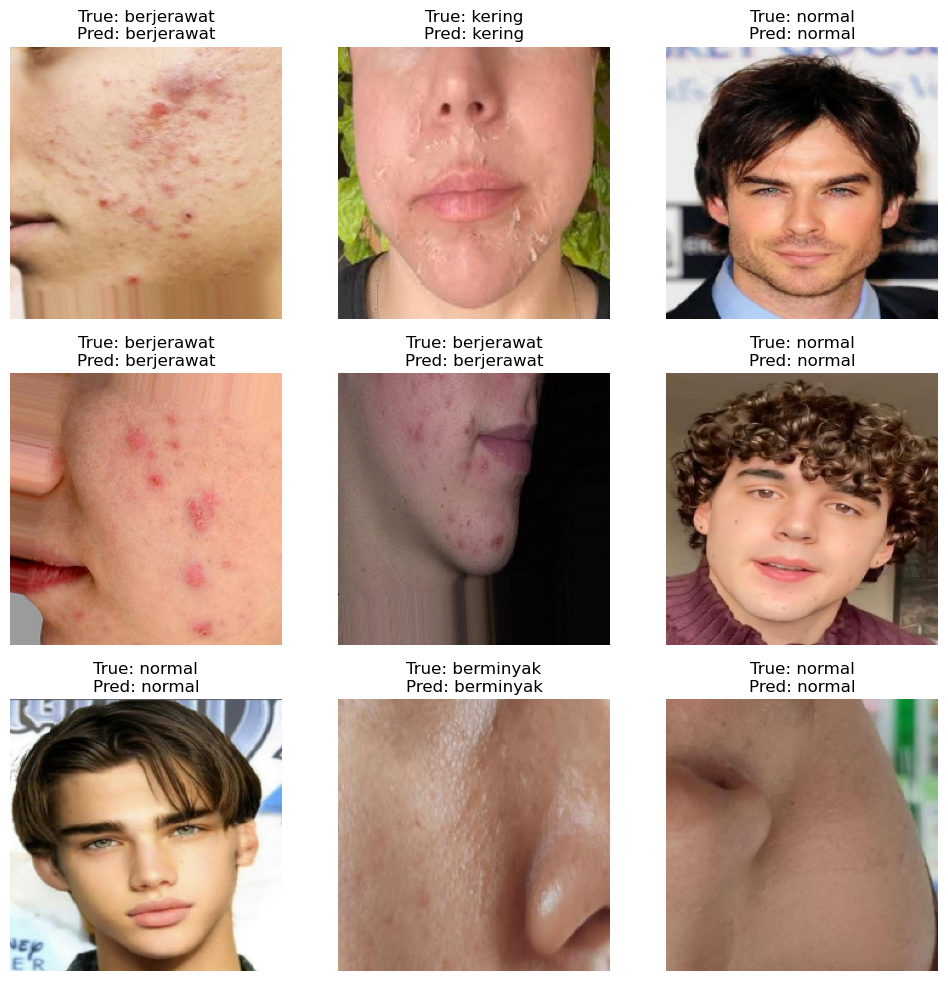

In [20]:
# Get a batch of images and their corresponding labels from the test generator
images, labels = next(val_generator)

# Make predictions on the batch of images
predictions = model.predict(images)

# Get the predicted class for each image
predicted_classes = np.argmax(predictions, axis=1)

# The true labels are already integers (indices), so no need to apply np.argmax
true_classes = labels.astype(int)  # Ensure the true labels are integers

# Display the images with true and predicted labels
plt.figure(figsize=(12, 12))
for i in range(9):  # Display 9 images
    ax = plt.subplot(3, 3, i + 1)
    ax.imshow(images[i])  # Show the image
    ax.axis('off')

    predicted_label = int(predicted_classes[i])  # Ensure the predicted label is an integer
    true_label = int(true_classes[i])  # Ensure the true label is an integer

    # Get the true and predicted class labels
    true_class_name = list(test_generator.class_indices.keys())[true_label]
    predicted_class_name = list(test_generator.class_indices.keys())[predicted_label]

    # Show both the true and predicted labels
    ax.set_title(f"True: {true_class_name}\nPred: {predicted_class_name}")

plt.show()


Processing batch 1...
1/1 [==============================] - 0s 34ms/step
Processing batch 2...
1/1 [==============================] - 0s 35ms/step
Processing batch 3...
1/1 [==============================] - 0s 41ms/step
Processing batch 4...
1/1 [==============================] - 0s 43ms/step
Processing batch 5...
1/1 [==============================] - 0s 31ms/step
Processing batch 6...
1/1 [==============================] - 0s 32ms/step
Processing batch 7...
1/1 [==============================] - 0s 27ms/step
Processing batch 8...
1/1 [==============================] - 0s 31ms/step
Processing batch 9...
1/1 [==============================] - 0s 31ms/step
Processing batch 10...
1/1 [==============================] - 0s 25ms/step

Classification Report:
              precision    recall  f1-score   support

  berjerawat       0.97      0.97      0.97        97
   berminyak       0.75      0.84      0.79        56
      kering       0.76      0.85      0.80        73
      normal      

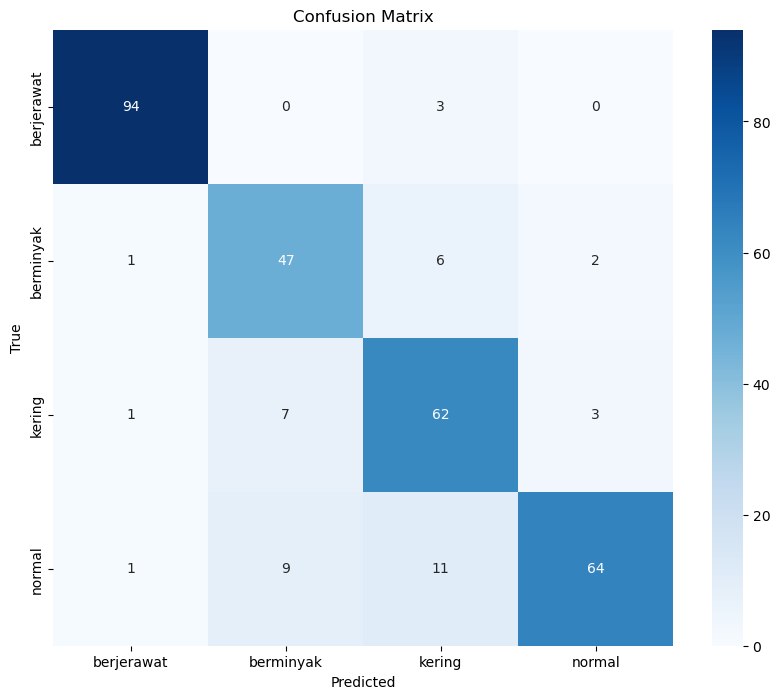

In [21]:
# Initialize lists to hold true and predicted labels
true_labels = []
predicted_labels = []

# Set a limit for the number of batches to process
max_batches = 10  # Change this number depending on how many batches you want to process
batch_count = 0

# Iterate over the validation dataset to accumulate true and predicted labels
for images, labels in val_generator:
    batch_count += 1
    print(f"Processing batch {batch_count}...")

    # Make predictions on the batch of images
    predictions = model.predict(images)

    # Get the predicted class for each image (argmax along axis 1)
    predicted_classes = np.argmax(predictions, axis=1)

    # The true labels are already integers (indices), so no need for argmax
    true_classes = labels.astype(int)  # Ensure the true labels are integers

    # Append to the lists
    true_labels.extend(true_classes)
    predicted_labels.extend(predicted_classes)

    # Break the loop if we've processed the max number of batches
    if batch_count >= max_batches:
        break

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Get the class names from the generator (same as before)
class_names = list(val_generator.class_indices.keys())

# Print precision, recall, F1-score, and support for each class
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Plot the confusion matrix using seaborn heatmap for better visualization
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [22]:
# To save the model in HDF5 format (.h5)
model.save('SkinTypeDetectionModel.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


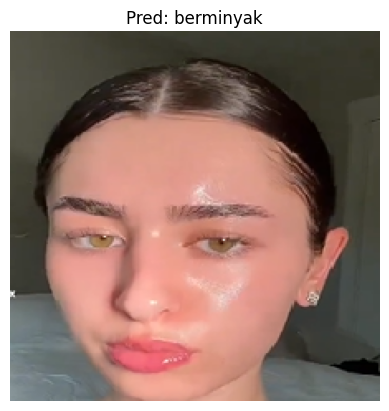

Predicted probabilities: [[4.5506626e-05 9.7510976e-01 1.5095659e-03 2.3335196e-02]]
Predicted class index: 1
Predicted class name: berminyak


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load the model
model = load_model('SkinTypeDetectionModel.h5')

# Define the mapping of class indices to class names
class_names = {
    0: 'berjerawat',
    1: 'berminyak',
    2: 'kering',
    3: 'normal'
}

# Function to load and predict a single image
def predict_single_image(img_path, model):
    # Load the image
    img = image.load_img(img_path, target_size=(224, 224))  # Ensure size matches model input
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Rescale pixel values

    # Make prediction
    predictions = model.predict(img_array)

    # Get the predicted class (the index with the highest probability)
    predicted_class = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_names.get(predicted_class, "Unknown")  # Get the class name

    # Display the image along with predicted label
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Pred: {predicted_class_name}")
    plt.show()

    # Debugging
    print(f"Predicted probabilities: {predictions}")
    print(f"Predicted class index: {predicted_class}")
    print(f"Predicted class name: {predicted_class_name}")

# Example usage:
img_path = 'Test Data/test_data2.png'  # Replace with the actual path to your image
predict_single_image(img_path, model)